# 03 - U-Net 2D Baseline

This notebook:
1. Trains a U-Net 2D model for slice interpolation
2. Evaluates on test set with R=2 and R=3
3. Saves model checkpoints and results

In [ ]:
# Mount Drive and setup
from google.colab import drive
drive.mount('/content/drive')

!pip install nibabel SimpleITK scikit-image PyYAML tqdm seaborn tensorboard -q

import sys, os
PROJECT_ROOT = "/content/drive/MyDrive/TLCN"
sys.path.insert(0, PROJECT_ROOT)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 45.5 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import json

# Verify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU available!")

GPU: NVIDIA L4
VRAM: 23.7 GB


In [ ]:
from src.utils.config import load_config
from src.utils.seed import set_seed
from src.data.ct_org_loader import CTORGLoader
from src.data.sparse_simulator import SparseSimulator
from src.data.dataset import UNetSliceDataset
from src.models.unet2d import UNet2D
from src.training.trainer_unet import TrainerUNet
from src.evaluation.metrics import evaluate_volume

config = load_config(os.path.join(PROJECT_ROOT, "configs/default.yaml"))
set_seed(config["training"]["seed"])

OUTPUT_DIR = os.path.join(config["data"]["output_root"], "unet_baseline")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
loader = CTORGLoader(
    dataset_root=config["data"]["dataset_root"],
    hu_min=config["data"]["hu_min"],
    hu_max=config["data"]["hu_max"],
)
available_cases = loader.get_available_cases()
split = CTORGLoader.get_split(
    available_cases,
    config["data"]["test_cases"],
    config["data"]["val_cases"],
)
print(f"Train: {len(split['train'])}, Val: {len(split['val'])}, Test: {len(split['test'])}")

Train: 98, Val: 21, Test: 21


In [ ]:
# Prepare training data for R=2
# Load a subset of training volumes (memory-efficient)
R = 2
NUM_TRAIN_VOLUMES = 20  # Use subset for faster training
NUM_VAL_VOLUMES = 5

print(f"Loading {NUM_TRAIN_VOLUMES} training volumes...")
train_volumes = []
for case_idx in tqdm(split["train"][:NUM_TRAIN_VOLUMES]):
    try:
        vol, _, _ = loader.load_and_preprocess(case_idx)
        train_volumes.append(vol)
    except Exception as e:
        print(f"  Skipping case {case_idx}: {e}")

print(f"Loading {NUM_VAL_VOLUMES} validation volumes...")
val_volumes = []
for case_idx in tqdm(split["val"][:NUM_VAL_VOLUMES]):
    try:
        vol, _, _ = loader.load_and_preprocess(case_idx)
        val_volumes.append(vol)
    except Exception as e:
        print(f"  Skipping case {case_idx}: {e}")

print(f"\nTrain volumes: {len(train_volumes)}, Val volumes: {len(val_volumes)}")

Loading 20 training volumes...


100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


Loading 5 validation volumes...


100%|██████████| 5/5 [00:37<00:00,  7.58s/it]


Train volumes: 20, Val volumes: 5


In [ ]:
# Create PyTorch datasets
from torch.utils.data import DataLoader

train_dataset = UNetSliceDataset(
    train_volumes, sparse_ratio=R, augment=True
)
val_dataset = UNetSliceDataset(
    val_volumes, sparse_ratio=R, augment=False
)

unet_config = config["unet"]
train_loader = DataLoader(
    train_dataset,
    batch_size=unet_config["batch_size"],
    shuffle=True,
    num_workers=config["training"]["num_workers"],
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=unet_config["batch_size"],
    shuffle=False,
    num_workers=config["training"]["num_workers"],
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Batch size: {unet_config['batch_size']}")

# Verify a batch
batch = next(iter(train_loader))
print(f"Input shape: {batch['input'].shape}")
print(f"Target shape: {batch['target'].shape}")

Train samples: 1928
Val samples: 1466
Batch size: 8
Input shape: torch.Size([8, 2, 512, 512])
Target shape: torch.Size([8, 1, 512, 512])


In [ ]:
# Create U-Net model
model = UNet2D(
    in_channels=unet_config["in_channels"],
    out_channels=unet_config["out_channels"],
    features=unet_config["features"],
)
print(f"U-Net parameters: {model.count_parameters():,}")

# Create trainer
trainer = TrainerUNet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=unet_config["lr"],
    num_epochs=unet_config["num_epochs"],
    scheduler_step=unet_config["scheduler_step"],
    scheduler_gamma=unet_config["scheduler_gamma"],
    mixed_precision=config["training"]["mixed_precision"],
    checkpoint_dir=os.path.join(OUTPUT_DIR, f"checkpoints_R{R}"),
    device=device,
)

U-Net parameters: 7,762,753


/content/drive/MyDrive/TLCN/src/training/trainer_unet.py:69: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=mixed_precision)


In [ ]:
# Train
print("Starting U-Net training...")
history = trainer.train()
print("\nTraining complete!")

Starting U-Net training...


/content/drive/MyDrive/TLCN/src/training/trainer_unet.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_unet.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):


Epoch 1/50 | Train Loss: 0.088215 | Val Loss: 0.046990 | Val PSNR: 29.68 dB | LR: 1.00e-04 | Time: 74.8s
Epoch 2/50 | Train Loss: 0.030020 | Val Loss: 0.035426 | Val PSNR: 32.60 dB | LR: 1.00e-04 | Time: 63.4s
Epoch 3/50 | Train Loss: 0.023845 | Val Loss: 0.020741 | Val PSNR: 35.69 dB | LR: 1.00e-04 | Time: 64.1s
Epoch 4/50 | Train Loss: 0.019987 | Val Loss: 0.007475 | Val PSNR: 35.97 dB | LR: 1.00e-04 | Time: 63.9s
Epoch 5/50 | Train Loss: 0.015966 | Val Loss: 0.036095 | Val PSNR: 36.46 dB | LR: 1.00e-04 | Time: 63.7s
Epoch 6/50 | Train Loss: 0.013713 | Val Loss: 0.007345 | Val PSNR: 37.75 dB | LR: 1.00e-04 | Time: 63.9s
Epoch 7/50 | Train Loss: 0.012286 | Val Loss: 0.016698 | Val PSNR: 36.45 dB | LR: 1.00e-04 | Time: 63.7s
Epoch 8/50 | Train Loss: 0.012455 | Val Loss: 0.020258 | Val PSNR: 38.79 dB | LR: 1.00e-04 | Time: 63.7s
Epoch 9/50 | Train Loss: 0.010754 | Val Loss: 0.034056 | Val PSNR: 29.19 dB | LR: 1.00e-04 | Time: 63.7s
Epoch 10/50 | Train Loss: 0.012486 | Val Loss: 0.024058

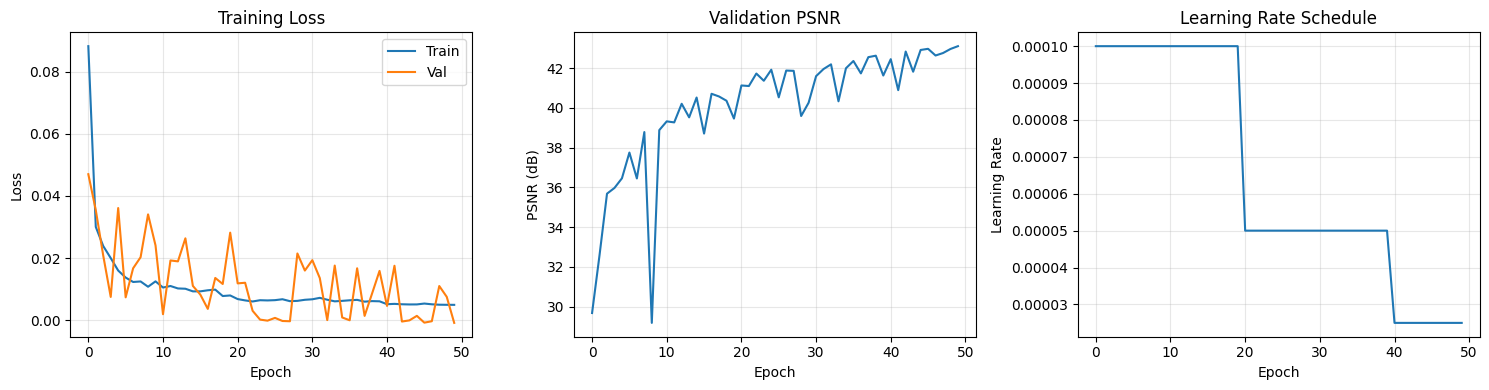

In [ ]:
# Plot training curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history["train_loss"], label="Train")
if history["val_loss"]:
    axes[0].plot(history["val_loss"], label="Val")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if history["val_psnr"]:
    axes[1].plot(history["val_psnr"])
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("PSNR (dB)")
    axes[1].set_title("Validation PSNR")
    axes[1].grid(True, alpha=0.3)

axes[2].plot(history["lr"])
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "training_curves.png"), dpi=150)
plt.show()

In [ ]:
# Evaluate on test set - STABLE BATCH VERSION
import pandas as pd
import torch
import gc

# Load best model
trainer.load_checkpoint("best.pt")

all_results = {}

for R in config["data"]["sparse_ratios"]:
    key = f"unet_R{R}"
    all_results[key] = {}
    simulator = SparseSimulator(sparse_ratio=R)
    psnr_list = []
    ssim_list = []

    for case_idx in tqdm(split["test"], desc=f"U-Net eval R={R}"):
        try:
            volume, labels, _ = loader.load_and_preprocess(case_idx)
            sparse_data = simulator.simulate(volume)
            H, W, D = volume.shape

            # Get all interpolation pairs
            pairs = simulator.get_interpolation_pairs(volume)

            # Collect inputs
            all_inputs = []
            for pair in pairs:
                s_before = torch.from_numpy(pair["slice_before"]).float()
                s_after = torch.from_numpy(pair["slice_after"]).float()
                input_tensor = torch.stack([s_before, s_after]).unsqueeze(0)
                all_inputs.append(input_tensor)

            # Batch predict with SMALLER batches (avoid OOM)
            predictions = np.zeros(
                (H, W, len(sparse_data["target_indices"])), dtype=np.float32
            )

            batch_size = 16  # Process 16 at a time
            trainer.model.eval()

            with torch.no_grad():
                for i in range(0, len(all_inputs), batch_size):
                    end_idx = min(i + batch_size, len(all_inputs))
                    batch = torch.cat(all_inputs[i:end_idx], dim=0).to(device)

                    with torch.cuda.amp.autocast(enabled=trainer.mixed_precision):
                        preds = trainer.model(batch)

                    # Copy predictions
                    for j, pred in enumerate(preds):
                        idx = i + j
                        if idx < len(sparse_data["target_indices"]):
                            pred_np = pred.squeeze().cpu().numpy()
                            pred_np = np.clip(pred_np, 0, 1)
                            predictions[:, :, idx] = pred_np

                    # Free GPU memory
                    del batch, preds

            # Free memory
            del all_inputs
            torch.cuda.empty_cache()

            # Evaluate
            result = evaluate_volume(
                predictions,
                sparse_data["target_slices"],
                sparse_data["target_indices"],
                labels=labels,
            )
            all_results[key][case_idx] = result["summary"]
            psnr_list.append(result["summary"]["mean_psnr"])
            ssim_list.append(result["summary"]["mean_ssim"])

            # Clean up
            del volume, sparse_data, predictions, result
            gc.collect()

        except Exception as e:
            print(f"  Error on case {case_idx}: {e}")
            import traceback
            traceback.print_exc()

    print(f"U-Net R={R}: PSNR={np.mean(psnr_list):.2f} dB, SSIM={np.mean(ssim_list):.4f}")


U-Net eval R=2:   0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipython-input-1946170612.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=trainer.mixed_precision):
U-Net eval R=2:   5%|▍         | 1/21 [00:24<08:06, 24.32s/it]/tmp/ipython-input-1946170612.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=trainer.mixed_precision):
U-Net eval R=2:  10%|▉         | 2/21 [01:26<14:50, 46.86s/it]/tmp/ipython-input-1946170612.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=trainer.mixed_precision):
U-Net eval R=2:  14%|█▍        | 3/21 [24:30<2:27:03, 490.18s/it]


KeyboardInterrupt: 

In [ ]:
# Save results
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}
    return obj

with open(os.path.join(OUTPUT_DIR, "unet_results.json"), "w") as f:
    json.dump(convert_to_serializable(all_results), f, indent=2)

print(f"Results saved to {OUTPUT_DIR}")
print("\nU-Net baseline evaluation complete!")